# Gold Layer ETL
Time to ingest data into empty schemas once again. This time we are bringing the data from the silver layer into the gold layer. 

In [0]:
import seaborn as sns
import matplotlib.pyplot as plt
import pyspark.sql.functions as F

### a) Customer Profile Table
Which features of the customer base are the most relevant is maximizing expenditure?

In [0]:
%sql
INSERT INTO gold.customer_profile
SELECT
    c.education,
    c.marital_status,
    c.kidhome,
    c.teenhome,
    c.income,
    c.complain,

    -- Total Spending = MntWines + MntFruits + ... + MntSweetProds (Obs: *no* MntGoldProds, as its a different kind of category)  
    SUM(
        f.MntWines +
        f.MntFruits +
        f.MntMeatProducts +
        f.MntFishProducts +
        f.MntSweetProducts
    ) AS total_spending,

    -- Average Spending 
    AVG(
        f.MntWines +
        f.MntFruits +
        f.MntMeatProducts +
        f.MntFishProducts +
        f.MntSweetProducts
    ) AS avg_spent_per_customer

FROM silver.FACT_Sales f
JOIN silver.DIM_Customer c
  ON f.fk_customer = c.id_customer

GROUP BY
    c.education,
    c.marital_status,
    c.kidhome,
    c.teenhome,
    c.income,
    c.complain;


num_affected_rows,num_inserted_rows
2008,2008


In [0]:
%sql
-- Test
SELECT * FROM gold.customer_profile 
ORDER BY total_spending DESC 

education,marital_status,kidhome,teenhome,income,complain,total_spending,avg_spent_per_customer
Master,Single,0,0,90638.0,0,4858.0,2429.0
2n Cycle,Married,0,0,82347.0,0,3580.0,1790.0
Graduation,Together,0,0,87679.0,0,2491.0,2491.0
Graduation,Single,0,0,93790.0,0,2304.0,2304.0
Graduation,Married,0,0,75759.0,0,2304.0,2304.0
Master,Married,1,1,62845.0,0,2288.0,1144.0
PhD,Married,0,0,69098.0,0,2262.0,2262.0
Master,Married,0,0,90226.0,0,2244.0,2244.0
PhD,Married,0,0,80360.0,0,2188.0,2188.0
Master,Single,0,0,91712.0,0,2169.0,2169.0


In [0]:
%sql
SELECT * FROM gold.customer_profile 
ORDER BY total_spending DESC LIMIT 10

education,marital_status,kidhome,teenhome,income,complain,total_spending,avg_spent_per_customer
Master,Single,0,0,90638.0,0,4858.0,2429.0
2n Cycle,Married,0,0,82347.0,0,3580.0,1790.0
Graduation,Together,0,0,87679.0,0,2491.0,2491.0
Graduation,Single,0,0,93790.0,0,2304.0,2304.0
Graduation,Married,0,0,75759.0,0,2304.0,2304.0
Master,Married,1,1,62845.0,0,2288.0,1144.0
PhD,Married,0,0,69098.0,0,2262.0,2262.0
Master,Married,0,0,90226.0,0,2244.0,2244.0
PhD,Married,0,0,80360.0,0,2188.0,2188.0
Master,Single,0,0,91712.0,0,2169.0,2169.0


Not very useful, as the combinations are too many, but we can already see which (highly specific) groups are the biggest spenders. The master's graduates who are single and have no offspring take the lead.

In [0]:
df_gold = spark.table("gold.customer_profile")

df_gold.select(
    F.corr("income", "total_spending").alias("corr_income_spending")
).display()


corr_income_spending
0.6445657432546494


As expected, the correlation between Income and Total Spending is positive and moderate to strong, at 0.64

In [0]:
%sql
SELECT
  education,
  ROUND(AVG(total_spending), 2) AS avg_spending
FROM gold.customer_profile
GROUP BY education
ORDER BY avg_spending DESC;

education,avg_spending
PhD,648.03
Master,583.32
Graduation,576.03
2n Cycle,456.93
Basic,61.16


Also to be expected, we find PhDs at the top of the spending ranking and people with Basic education at the bottom. Usually these are correlated with Income.

In [0]:
%sql
SELECT
  marital_status,
  ROUND(AVG(total_spending),2) AS avg_spending
FROM gold.customer_profile
GROUP BY marital_status
ORDER BY avg_spending DESC;


marital_status,avg_spending
Widow,703.58
Together,570.82
Single,570.23
Divorced,568.09
Married,556.69


It is notable that the 'Married' marital status is the very last one in spending. Also the incorrect categories are gone, but the new 'Unknown' category is not here for some reason...

In [0]:
df_gold = spark.table("gold.customer_profile")

df_gold.select(
    F.corr("kidhome", "total_spending").alias("corr_income_spending")
).display()


corr_income_spending
-0.5468908372141442


In [0]:
df_gold = spark.table("gold.customer_profile")

df_gold.select(
    F.corr("teenhome", "total_spending").alias("corr_income_spending")
).display()


corr_income_spending
-0.1372884236365923


Interestingly, having offspring is negatively correlated with Total Spending. Additionaly, the lowering strength of the correlation might suggest a relation to the maturity of the child.

In [0]:
%sql
SELECT
  kidhome,
  ROUND(AVG(total_spending),2) AS avg_spending
FROM gold.customer_profile
GROUP BY kidhome
ORDER BY kidhome;


kidhome,avg_spending
0,852.59
1,184.32
2,107.37


In [0]:
%sql
SELECT
  teenhome,
  ROUND(AVG(total_spending),2) AS avg_spending
FROM gold.customer_profile
GROUP BY teenhome
ORDER BY teenhome;


teenhome,avg_spending
0,653.77
1,475.85
2,539.65


In summary:

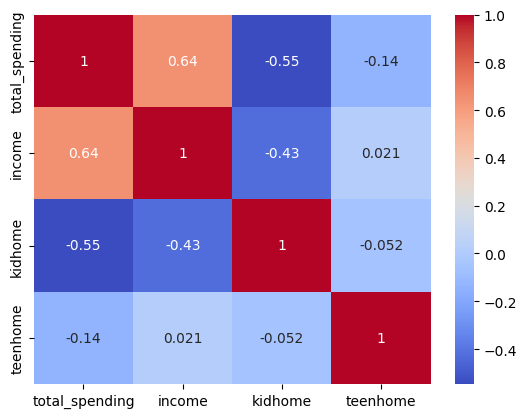

In [0]:
pdf = df_gold.select(
    "total_spending",
    "income",
    "kidhome",
    "teenhome"
).toPandas()

sns.heatmap(pdf.corr(), annot=True, cmap="coolwarm")
plt.show()

Evidently total spending is positively correlated with income, but it is intriguing that is is *negatively* correlated with having kids at home. Having a teen at home seems not to be relevant. This could suggest that it is wiser to market the company's products to young adults, with income but no family yet.

### b) Promo Effectiveness Table
Which features of the customer base are most relevant to the effectiveness of promotional campaigns?

In [0]:
%skip
%sql
CREATE OR REPLACE TABLE gold.promo_acceptance_rate
USING DELTA
AS

SELECT
    campaign,
    COUNT(*) AS total_customers,
    SUM(accepted) AS accepted_customers,
    SUM(accepted) / COUNT(*) AS acceptance_rate
FROM (
    SELECT 'Campaign_1' AS campaign, AcceptedCmp1 AS accepted FROM silver.raw_data
    UNION ALL
    SELECT 'Campaign_2', AcceptedCmp2 FROM silver.raw_data
    UNION ALL
    SELECT 'Campaign_3', AcceptedCmp3 FROM silver.raw_data
    UNION ALL
    SELECT 'Campaign_4', AcceptedCmp4 FROM silver.raw_data
    UNION ALL
    SELECT 'Campaign_5', AcceptedCmp5 FROM silver.raw_data
    UNION ALL
    SELECT 'Last_Campaign', Response FROM silver.raw_data
) t
GROUP BY campaign;


---------------------------------------------------------------------------
AnalysisException                         Traceback (most recent call last)
File <command-5493077806459628>, line 1
----> 1 get_ipython().run_cell_magic('sql', '', "CREATE OR REPLACE TABLE gold.promo_acceptance_rate\nUSING DELTA\nAS\n\nSELECT\n    campaign,\n    COUNT(*) AS total_customers,\n    SUM(accepted) AS accepted_customers,\n    SUM(accepted) / COUNT(*) AS acceptance_rate\nFROM (\n    SELECT 'Campaign_1' AS campaign, AcceptedCmp1 AS accepted FROM silver.raw_data\n    UNION ALL\n    SELECT 'Campaign_2', AcceptedCmp2 FROM silver.raw_data\n    UNION ALL\n    SELECT 'Campaign_3', AcceptedCmp3 FROM silver.raw_data\n    UNION ALL\n    SELECT 'Campaign_4', AcceptedCmp4 FROM silver.raw_data\n    UNION ALL\n    SELECT 'Campaign_5', AcceptedCmp5 FROM silver.raw_data\n    UNION ALL\n    SELECT 'Last_Campaign', Response FROM silver.raw_data\n) t\nGROUP BY campaign;\n")

File /databricks/python/lib/python3.12/site-p

In [0]:
%skip
%sql
INSERT INTO gold.promo_acceptance_rate
SELECT
    'Campaign 1' AS campaign_num,
    AVG(p.AcceptedCmp1) AS acceptance_rate,
    COUNT(*) AS total_customers
FROM silver.FACT_Sales f
JOIN silver.DIM_Promo p
  ON f.fk_promo = p.id_promo;

INSERT INTO gold.promo_acceptance_rate
SELECT
    'Campaign 2' AS campaign_num,
    AVG(p.AcceptedCmp2) AS acceptance_rate,
    COUNT(*) AS total_customers
FROM silver.FACT_Sales f
JOIN silver.DIM_Promo p
  ON f.fk_promo = p.id_promo;

INSERT INTO gold.promo_acceptance_rate
SELECT
    'Campaign 3' AS campaign_num,
    AVG(p.AcceptedCmp3) AS acceptance_rate,
    COUNT(*) AS total_customers
FROM silver.FACT_Sales f
JOIN silver.DIM_Promo p
  ON f.fk_promo = p.id_promo;

INSERT INTO gold.promo_acceptance_rate
SELECT
    'Campaign 4' AS campaign_num,
    AVG(p.AcceptedCmp4) AS acceptance_rate,
    COUNT(*) AS total_customers
FROM silver.FACT_Sales f
JOIN silver.DIM_Promo p
  ON f.fk_promo = p.id_promo;

INSERT INTO gold.promo_acceptance_rate
SELECT
    'Campaign 5' AS campaign_num,
    AVG(p.AcceptedCmp5) AS acceptance_rate,
    COUNT(*) AS total_customers
FROM silver.FACT_Sales f
JOIN silver.DIM_Promo p
  ON f.fk_promo = p.id_promo;

INSERT INTO gold.promo_acceptance_rate
SELECT
    'Last Campaign (6)' AS campaign_num,
    AVG(p.Response) AS acceptance_rate,
    COUNT(*) AS total_customers
FROM silver.FACT_Sales f
JOIN silver.DIM_Promo p
  ON f.fk_promo = p.id_promo;




num_affected_rows,num_inserted_rows
1,1


In [0]:
%skip
display(spark.table("gold.promo_acceptance_rate"))

---------------------------------------------------------------------------
AnalysisException                         Traceback (most recent call last)
File <command-5493077806459631>, line 1
----> 1 display(spark.table("gold.promo_acceptance_rate"))

File /databricks/python_shell/lib/dbruntime/display.py:133, in Display.display(self, input, *args, **kwargs)
    131     pass
    132 elif self._cf_helper is not None and isinstance(input, ConnectDataFrame):
--> 133     self.display_connect_table(input, **kwargs)
    134 elif isinstance(input, ConnectDataFrame):
    135     if input.isStreaming:

File /databricks/python_shell/lib/dbruntime/display.py:93, in Display.display_connect_table(self, df, **kwargs)
     88 except Exception as e:
     89     raise type(
     90         e
     91     )("IPython shell encountered an error or was missing data, please restart the notebook or contact Databricks support"
     92       ) from e
---> 93 if df.isStreaming:
     94     self.cf_helper.display

In [0]:
%skip
%sql
SELECT * 
FROM gold.promo_acceptance_rate
ORDER BY acceptance_rate DESC

campaign_num,acceptance_rate,total_customers
Last Campaign (6),0.15194174757281553,2060
Campaign 4,0.0766990291262136,2060
Campaign 3,0.07330097087378641,2060
Campaign 5,0.07184466019417475,2060
Campaign 1,0.06553398058252427,2060
Campaign 2,0.01262135922330097,2060


In [0]:
%sql
INSERT INTO gold.campaign_acceptance
SELECT
    'Campaign_1' AS campaign_num,
    COUNT(DISTINCT f.fk_customer) AS total_customers,
    SUM(CASE WHEN p.AcceptedCmp1 = 1 THEN 1 ELSE 0 END) AS accepted_customers,
    SUM(CASE WHEN p.AcceptedCmp1 = 1 THEN 1 ELSE 0 END)
      / COUNT(DISTINCT f.fk_customer) AS acceptance_rate
FROM silver.FACT_Sales f
JOIN silver.DIM_Promo p
  ON f.fk_promo = p.id_promo;

INSERT INTO gold.campaign_acceptance
SELECT
    'Campaign_2',
    COUNT(DISTINCT f.fk_customer),
    SUM(CASE WHEN p.AcceptedCmp2 = 1 THEN 1 ELSE 0 END),
    SUM(CASE WHEN p.AcceptedCmp2 = 1 THEN 1 ELSE 0 END)
      / COUNT(DISTINCT f.fk_customer)
FROM silver.FACT_Sales f
JOIN silver.DIM_Promo p
  ON f.fk_promo = p.id_promo;

INSERT INTO gold.campaign_acceptance
SELECT
    'Campaign_3',
    COUNT(DISTINCT f.fk_customer),
    SUM(CASE WHEN p.AcceptedCmp3 = 1 THEN 1 ELSE 0 END),
    SUM(CASE WHEN p.AcceptedCmp3 = 1 THEN 1 ELSE 0 END)
      / COUNT(DISTINCT f.fk_customer)
FROM silver.FACT_Sales f
JOIN silver.DIM_Promo p
  ON f.fk_promo = p.id_promo;

INSERT INTO gold.campaign_acceptance
SELECT
    'Campaign_4',
    COUNT(DISTINCT f.fk_customer),
    SUM(CASE WHEN p.AcceptedCmp4 = 1 THEN 1 ELSE 0 END),
    SUM(CASE WHEN p.AcceptedCmp4 = 1 THEN 1 ELSE 0 END)
      / COUNT(DISTINCT f.fk_customer)
FROM silver.FACT_Sales f
JOIN silver.DIM_Promo p
  ON f.fk_promo = p.id_promo;

INSERT INTO gold.campaign_acceptance
SELECT
    'Campaign_5',
    COUNT(DISTINCT f.fk_customer),
    SUM(CASE WHEN p.AcceptedCmp5 = 1 THEN 1 ELSE 0 END),
    SUM(CASE WHEN p.AcceptedCmp5 = 1 THEN 1 ELSE 0 END)
      / COUNT(DISTINCT f.fk_customer)
FROM silver.FACT_Sales f
JOIN silver.DIM_Promo p
  ON f.fk_promo = p.id_promo;

INSERT INTO gold.campaign_acceptance
SELECT
    'Campaign_6',
    COUNT(DISTINCT f.fk_customer),
    SUM(CASE WHEN p.Response = 1 THEN 1 ELSE 0 END),
    SUM(CASE WHEN p.Response= 1 THEN 1 ELSE 0 END)
      / COUNT(DISTINCT f.fk_customer)
FROM silver.FACT_Sales f
JOIN silver.DIM_Promo p
  ON f.fk_promo = p.id_promo;


num_affected_rows,num_inserted_rows
1,1


In [0]:
display(spark.table("gold.campaign_acceptance"))

campaign_num,total_customers,accepted_customers,acceptance_rate
Campaign_6,2009,313,0.15579890492782478
Campaign_5,2009,148,0.07366849178695868
Campaign_4,2009,158,0.07864609258337481
Campaign_3,2009,151,0.07516177202588352
Campaign_2,2009,26,0.012941762070681932
Campaign_1,2009,135,0.06719761075161772


In [0]:
%sql
SELECT * 
FROM gold.campaign_acceptance
ORDER BY acceptance_rate DESC

campaign_num,total_customers,accepted_customers,acceptance_rate
Campaign_6,2009,313,0.15579890492782478
Campaign_4,2009,158,0.07864609258337481
Campaign_3,2009,151,0.07516177202588352
Campaign_5,2009,148,0.07366849178695868
Campaign_1,2009,135,0.06719761075161772
Campaign_2,2009,26,0.012941762070681932


Fortunately for the company, its marketing efforts appear to be improving, as the most recent campaign achieved the highest acceptance rate.

### c) Product Performance Table
Which are the best performing products?

In [0]:
%sql
INSERT OVERWRITE gold.product_performance
WITH product_sales AS (

    -- Wines
    SELECT
        'Wines' AS product_category,
        fk_customer,
        MntWines AS revenue
    FROM silver.FACT_Sales
    WHERE MntWines > 0

    UNION ALL

    -- Fruits
    SELECT
        'Fruits',
        fk_customer,
        MntFruits
    FROM silver.FACT_Sales
    WHERE MntFruits > 0

    UNION ALL

    -- Meat
    SELECT
        'Meat Products',
        fk_customer,
        MntMeatProducts
    FROM silver.FACT_Sales
    WHERE MntMeatProducts > 0

    UNION ALL

    -- Fish
    SELECT
        'Fish Products',
        fk_customer,
        MntFishProducts
    FROM silver.FACT_Sales
    WHERE MntFishProducts > 0

    UNION ALL

    -- Sweets
    SELECT
        'Sweet Products',
        fk_customer,
        MntSweetProducts
    FROM silver.FACT_Sales
    WHERE MntSweetProducts > 0
),

aggregated AS (
    SELECT
        product_category,
        SUM(revenue)                    AS total_revenue,
        AVG(revenue)                    AS avg_revenue_per_customer,
        COUNT(DISTINCT fk_customer)     AS purchase_count
    FROM product_sales
    GROUP BY product_category
)

SELECT
    product_category,
    total_revenue,
    avg_revenue_per_customer,
    purchase_count,
    DENSE_RANK() OVER (ORDER BY total_revenue DESC) AS revenue_rank
FROM aggregated;


num_affected_rows,num_inserted_rows
5,5


In [0]:
display(spark.table("gold.product_performance"))

product_category,total_revenue,avg_revenue_per_customer,purchase_count,revenue_rank
Wines,625478,305.4091796875,1997,1
Meat Products,345164,167.63671685284118,2008,2
Fish Products,76840,45.17342739564962,1660,3
Sweet Products,55952,33.42413381123058,1636,4
Fruits,54016,31.92434988179669,1656,5


Not much can be concluded from just this table without greater context. Perhaps the company should stop selling fruits; perhaps it needs to bolster its marketing for fruits. Regardless, having awareness of the asymmetries between the different product categories would be absolutely essential for strategic thinking.

### d) Purchase Channel Summary Table
Which is the most popular method of purchasing?


In [0]:
%sql
CREATE OR REPLACE TABLE gold.purchase_channel_summary AS
SELECT
    ROUND(AVG(NumWebPurchases), 2) AS avg_web,
    ROUND(AVG(NumStorePurchases), 2) AS avg_store,
    ROUND(AVG(NumCatalogPurchases), 2) AS avg_catalog
FROM silver.fact_sales;

num_affected_rows,num_inserted_rows


In [0]:
display(spark.table("gold.purchase_channel_summary"))

avg_web,avg_store,avg_catalog
4.1,5.77,2.66


The average consumer purchases the least from the company's catalog and the most from physical stores. While for now there can only be conjecture about the reasons why, it is nevertheless a valuable insight taht might, for instance, suggest that catalogs are not worth mantaining, or that stores should at the very least receive the same level of attention and not be neglected.